<a href="https://colab.research.google.com/github/juankuntz/LPAE/blob/master/notebooks/MNIST_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we fit an LPAE to the MNIST dataset. For more info on the model and training procedure, see [here](https://lpae.readthedocs.io/en/latest/).

**Note**: The training runs significantly faster on a GPU (on Colab, select from the top bar Runtime -> 
Change runtime type -> accelerator -> GPU).

# Setup

Are you running this notebook on Colab or locally? In the former case, set the following COLAB parameter to true. In the latter, set it to false and specify the path to the repository.

In [1]:
COLAB = True

In [2]:
import os

# Specify path (the following command does the trick if
# you launched jupyter-lab from the notebook's directory).
REPOSITORY_PATH = os.path.dirname(os.getcwd())

In the former case, we need to download the respository:

In [3]:
%%capture

if COLAB:
    # Mount gdrive:
    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=False) 
    
    # Load the repository:
    import sys
    !rm -rf LPAE
    REPOSITORY_PATH = '/content/lpae'
    !git clone https://github.com/juankuntz/LPAE.git $REPOSITORY_PATH

In either case, we need the following modules:

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras.layers import Conv2DTranspose, Dense, Reshape, Input, Average, Rescaling, Flatten
from tensorflow.keras import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

Lastly, we add the repository to the system's path and load the LPAE object:

In [5]:
import sys

# Add repository to system path:
if REPOSITORY_PATH not in sys.path:
    sys.path.append(REPOSITORY_PATH)

# Import the LPAE object:
from src.autoencoders import LPAE

# Model definition and training

**Training data**: Let's fetch $10,000$ MNIST images to train our model with (we also fetch another $1000$ for testing):

In [6]:
(x, y), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x, y = tf.constant(x[:10000].astype('float32')[..., np.newaxis]), y[:10000]
x_test, y_test = tf.constant(x_test[:1000].astype('float32')[..., np.newaxis]), y_test[:1000]
data = tf.data.Dataset.from_tensor_slices(x)

11490434/11490434 [==============================] - 2s 0us/step


Let's check that these are what we expect:

In [7]:
#@title Definition of plot_images()
def plot_images(image_batch: tf.Tensor, names: list[str] = None) -> None:
    """
    Plots batch of images.

    Parameters
    ----------
    image_batch: tf.Tensor with dimensions (batch_size, 28, 28, 1)
        Batch of images.
    names: list[str] or None
        Corresponding list of names.
    """
    images = [image_batch[i, ...].numpy()[..., 0] 
            for i in range(image_batch.shape[0])]
    if not names:
        names = ['' for _ in images]
    grid_size = math.ceil(len(images) ** (1/2))
    for i, (image, name) in enumerate(zip(images, names)):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        ax.set_title(name)
        plt.imshow(255 - image.astype("uint8"), cmap='Greys')
        plt.axis("off")
    plt.gcf().tight_layout()    
    plt.show()

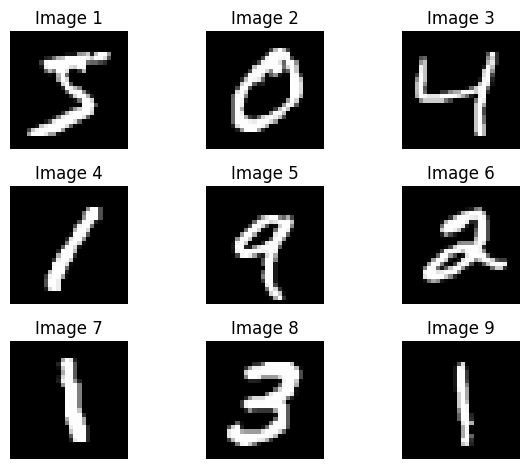

In [8]:
# Plot first nine images:
plot_images(x[:9], [f'Image {i+1}' for i in range(9)])

**Model definition**: To define the model, we need to choose the latent space's dimension and then define a decoder mapping from this space to the data space ($\mathbb{R}^{28\times28}$ as we are dealing with $28\times 28$ greyscale images). Let's try $2$ for the dimension and the simple convolutional decoder used in [this keras VAE tutorial](https://keras.io/examples/generative/vae/):

                    Decoder with 159169 parameters


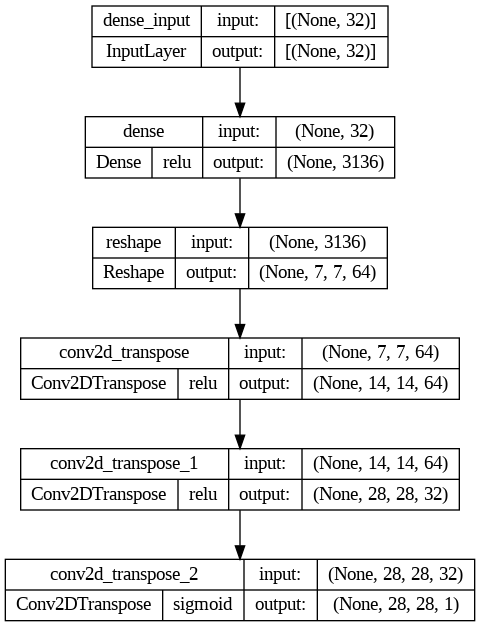

In [9]:
latent_dimensions = 32  
decoder = Sequential([Dense(7 * 7 * 64, activation="relu",
                             input_shape=(latent_dimensions,)),
                       Reshape((7, 7, 64)),
                       Conv2DTranspose(64, 3, activation="relu", strides=2,
                                       padding="same"),
                       Conv2DTranspose(32, 3, activation="relu", strides=2,
                                       padding="same"),
                       Conv2DTranspose(1, 3, activation="sigmoid",
                                       padding="same")
                       ], name='decoder')

n_parameters = np.sum([np.prod(v.get_shape().as_list()) for v in decoder.trainable_variables])
print(f'                    Decoder with {n_parameters} parameters')
print('===================================================================')
tf.keras.utils.plot_model(decoder, show_shapes=True, show_layer_activations=True)

We can now define the entire model:

In [10]:
model = LPAE(latent_dimensions=latent_dimensions, decoder=decoder, observation_noise_std=1e-2)

**Training**: Training entails optimizing over the parameters $\theta$ of the decoder. To do so, we use
- $10$ particles,
- a learning rate of $0.0005$ for the latent variable updates,
- and an RMSProp optimizer for the decoder's parameter updates.

The decoder's final layer uses a sigmoid activation function and, so, maps to $[0,1]^{28\times28}$. Hence, must normalize the images to lie in $[0,1]^{28\times28}$. We can get the model to do this internally for us by feeding it to appropiate  `preprocessor` and `postprocessor` layers (the former normalizes, the latter unnormalizes, and both must be [keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers)). We have all we need to configure the training:

In [11]:
n_particles = 10
model.compile(lv_learning_rate=5e-4, n_particles=n_particles,
              optimizer=RMSprop(),
              preprocessor=Rescaling(scale=1./255),
              postprocessor=Rescaling(scale=255.))

We can now train the model by calling its fit method, passing in the data, the number of epochs we want it to train for, and the batch size we'd like it to use:

In [12]:
model.fit(data=data, epochs=100, batch_size=256)  

Epoch 1/100


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


39/39 [==============================] - 16s 101ms/step - loss: 368211.8273
Epoch 2/100
39/39 [==============================] - 4s 103ms/step - loss: 253543.7172
Epoch 3/100
39/39 [==============================] - 4s 102ms/step - loss: 210137.0281
Epoch 4/100
39/39 [==============================] - 4s 103ms/step - loss: 162971.2457
Epoch 5/100
39/39 [==============================] - 4s 104ms/step - loss: 130770.4143
Epoch 6/100
39/39 [==============================] - 4s 103ms/step - loss: 107136.8209
Epoch 7/100
39/39 [==============================] - 4s 104ms/step - loss: 87598.8363
Epoch 8/100
39/39 [==============================] - 4s 113ms/step - loss: 74097.5792
Epoch 9/100
39/39 [==============================] - 4s 105ms/step - loss: 64045.0199
Epoch 10/100
39/39 [==============================] - 4s 106ms/step - loss: 56307.4004
Epoch 11/100
39/39 [==============================] - 4s 107ms/step - loss: 49819.8555
Epoch 12/100
39/39 [==============================] - 4s 

## Saving and loading the model

It's easy to save the fitted model so we don't have to re-train it every time we run this notebook:

In [13]:
if COLAB:
    # Set save directory in Google drive so that it's persistent across notebook re-starts:
    CHECKPOINT_PATH = 'gdrive/MyDrive/lpae_ckpts/checkpoint_0/'
else:
    CHECKPOINT_PATH = REPOSITORY_PATH + '/ckpts/checkpoint_0/'
model.save(CHECKPOINT_PATH)

To load it, use the from_save constructor method:

In [14]:
del model
model = LPAE.from_save(CHECKPOINT_PATH)

# Inference

We've fitted the model to the dataset, so what can we do with it? Before answering that question, let's get a bit more of a feel for how the model works. 

## Visualizing the posterior approximation

As discussed in the [docs](https://lpae.readthedocs.io/en/latest/) (in what follows, we use the notation introduced there), the model assumes that each image $y^m$ in our training set was generated by mapping a vector of latent variables $x^m$ to the image space via the decoder $f_{\Theta_K}:\mathbb{R}^{32}\to\mathbb{R}^{28\times28}$ (and adding a bit of Gaussian noise). It doesn't presume to know what $x^m$ is and instead offers $N:=10$ guesses it deems equally as likely: $X^{1,m}_K,\dots, X^{N,m}_K$ which we refer to as 'particles'. We can visualize them by plotting their coordinates one at a time:

                                 Particles for image 0.


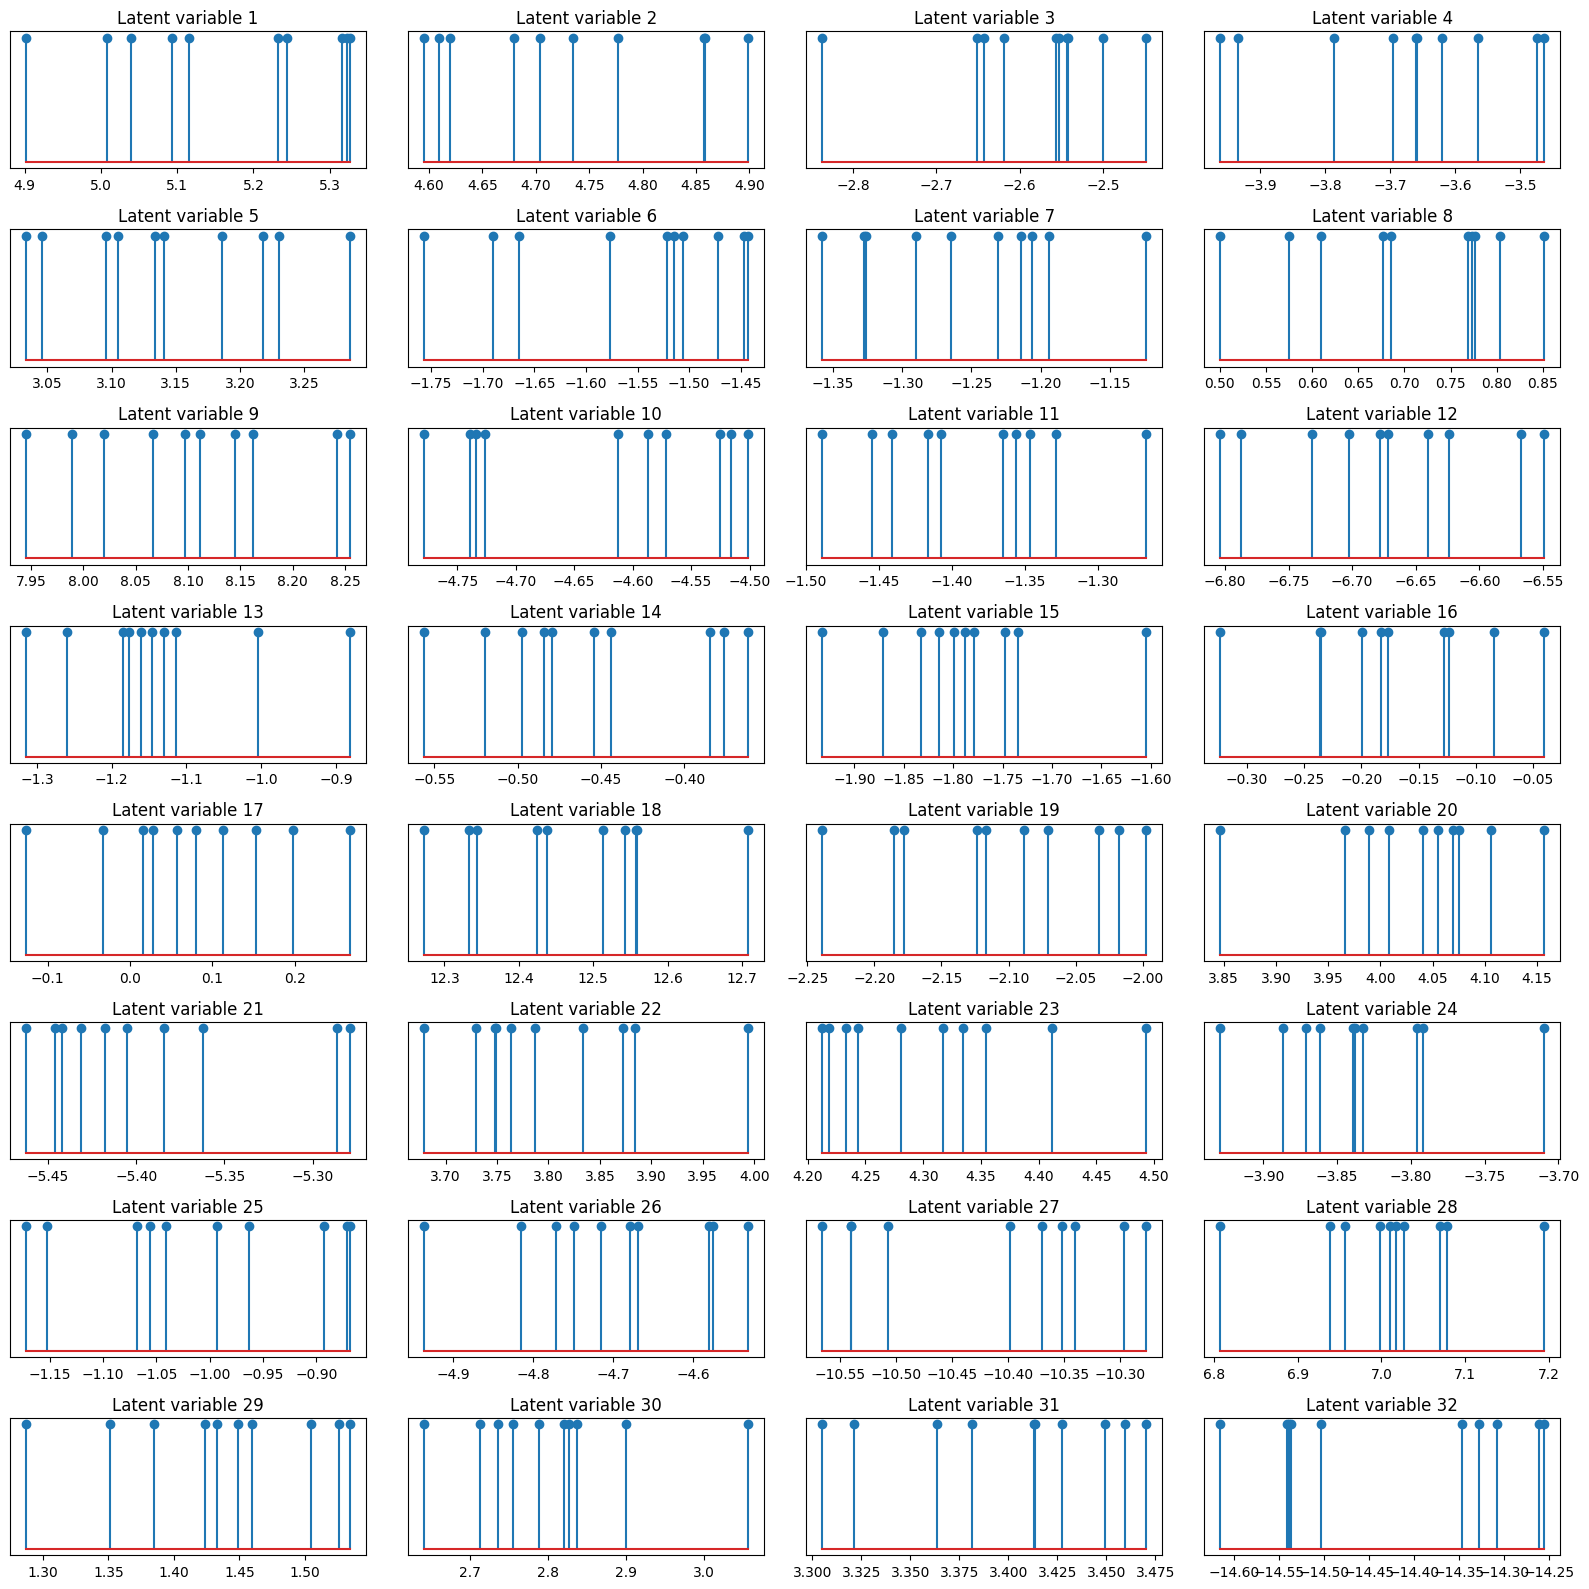

In [15]:
i = 0

# Get particles for the ith image:
particles = model.get_particles(index_batch=[i])[0, :, :]

# Plot them:
plt.figure(figsize=(16, 16))
grid_size = math.ceil(latent_dimensions ** (1/2))
for j in range(latent_dimensions):
    ax = plt.subplot(8, 4, j + 1)
    ax.set_title(f'Latent variable {j + 1}')
    ax.get_yaxis().set_visible(False)
    plt.stem(particles[:, j].numpy(), np.ones(10))
plt.gcf().tight_layout()   
print(f'                                 Particles for image {i}.')
print('==================================================================================')
plt.show()

Equivalently, we can think of the model returning, for each image $y^m$, a distribution over the possible values of $x^m$ defined by the empirical distribution of these particles: $N^{-1}\sum_{n=1}^N\delta_{X_K^{n,m}}$. We can visualize this distribution by examining its marginals (and with the help of a KDE):

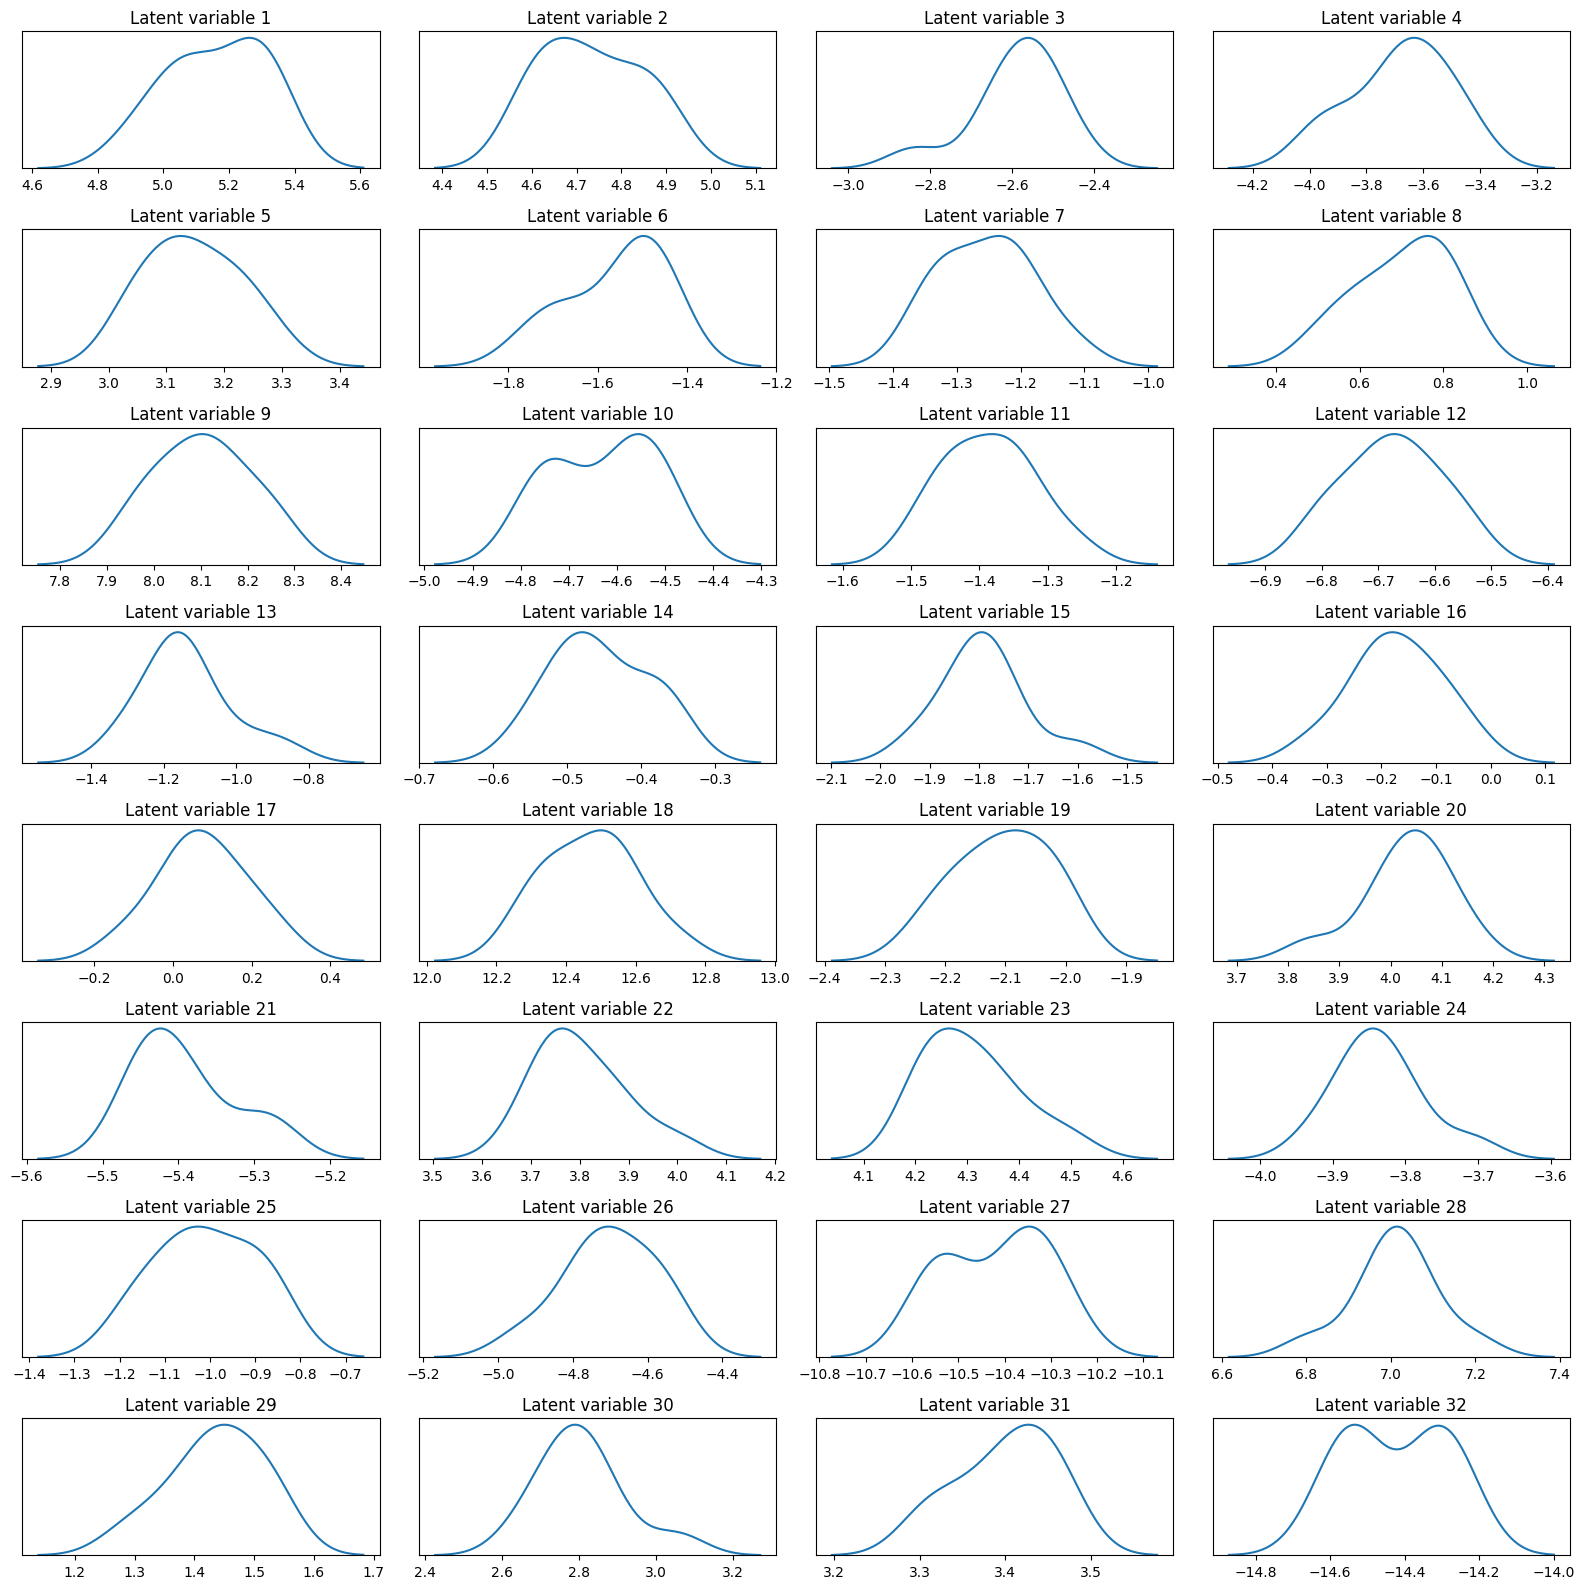

In [16]:
# Plot them:
plt.figure(figsize=(16, 16))
grid_size = math.ceil(latent_dimensions ** (1/2))
for j in range(latent_dimensions):
    ax = plt.subplot(8, 4, j + 1)
    ax.set_title(f'Latent variable {j + 1}')
    ax.get_yaxis().set_visible(False)
    sns.kdeplot(particles[:, j].numpy(), ax=ax)
plt.gcf().tight_layout()    
plt.show()

We refer to this distribution as an 'approximate posterior' because it approximates 

$$p_{\Theta_K}(x^m|y^m)=\frac{p_{\Theta_K}(x^m,y^m)}{p_{\Theta_K}(y^m)}.$$

While the distribution doesn't look particularly peaked, its pushforward through the decoder is remarkably peaked around the training image $y^m$. In other words, by pushing any of the particles through the decoder, we get an image almost indistinguishable from $y^m$:

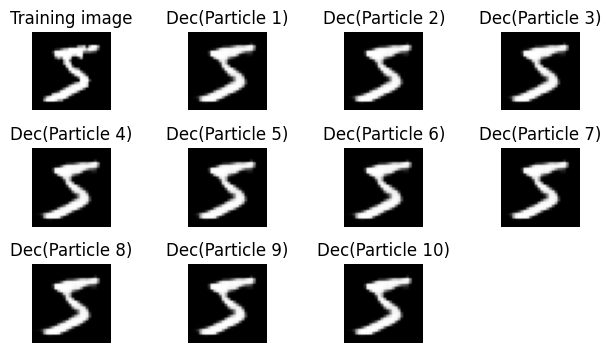

In [17]:
decoded_particles = model.decode_particles(index_batch=[i])
names = ['Training image'] + [f'Dec(Particle {j+1})' 
                              for j in range(n_particles)]
plot_images(tf.concat([x[i][tf.newaxis, ...], decoded_particles[0, ...]], axis=0), names)

## Image representations 

In short, the model learns representations of MNIST images: the representation of the $m^{th}$ image being the corresponding set of particles $\{X^{1,m}_K,\dots, X_K^{N,m}\}$. Or, equivalently, the particles' empirical distribution $N^{-1}\sum_{n=1}^N\delta_{X_K^{n,m}}$ or 'approximate posterior'.

To visualize all of these representations, we can plot (the first $4$ principle components of) all the particles. If we colour each of these by the corresponding's image label, we see that they (at least partially) cluster by label:

<a id='visualize_particles'></a>

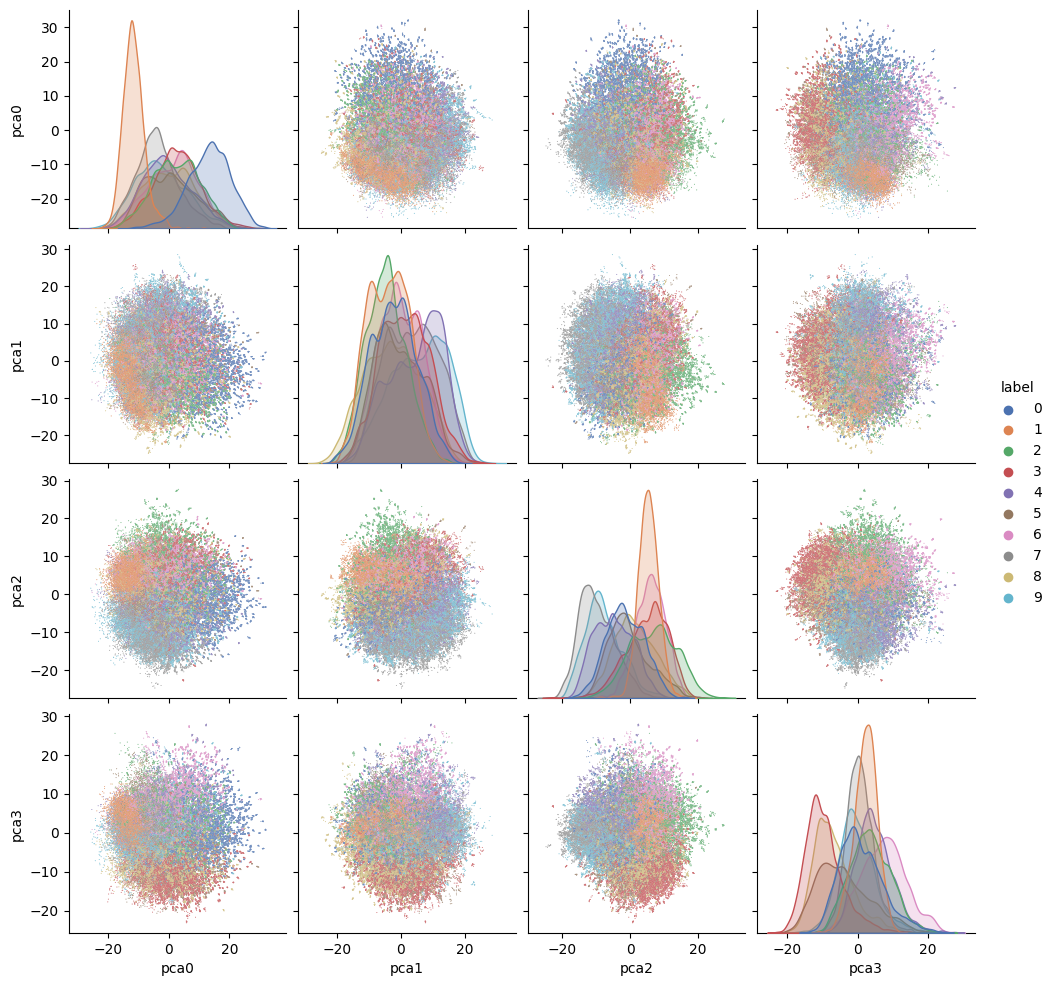

In [18]:
particles = pd.DataFrame(model.flatten_particles(model.get_particles()).numpy(),
                         columns=[f'Latent variable {i}' for i in range(latent_dimensions)])
particles_pca = PCA(n_components=4).set_output(transform='pandas').fit_transform(particles)
particles_pca['label'] = np.repeat(y, n_particles)
sns.pairplot(particles_pca, hue='label', palette='deep', plot_kws={'s': 0.5})

In particular, we can train a classifier on these representations to predict the image's label. However, for this simple dataset, a naive classifier trained on the raw image data does quite well and we don't gain much by training it on the representations (see the [notebook's end](#classify_images)). 

## Interpolating images in a semantically meaningful way

These representations, however, let us do certain things we'd struggle to do with the original data. For instance, if we linearly interpolate between two images, we just get a series of intermediate images where the first image fades out and the second fades in:

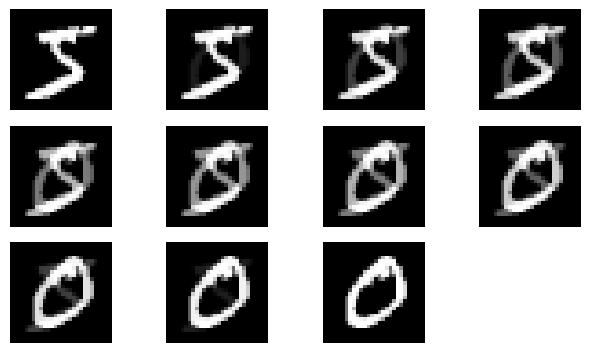

In [19]:
i, j = 0, 1
plot_images(tf.stack([(1 - t) * x[i] + t * x[j] for t in np.linspace(0, 1, 11)]))

On the other hand, if we pick a particle for each image, linearly interpolate between the two particles, and map the intermediate particles through the decoder, we get a semantically meaningful interpolation between to two images:

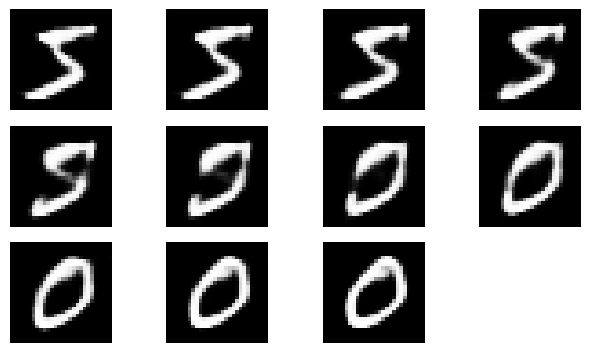

In [20]:
particle_i = model.get_particles((i,), 1)
particle_j = model.get_particles((j,), 1)
plot_images(model.decode(tf.concat([(1 - t) * particle_i + t * particle_j  for t in np.linspace(0, 1, 11)], axis=0))[:, 0,...])

## Generating fakes

Similarly, if we fit a mixture of Gaussians to the collection of all particles visualized [above](#visualize_particles), draw latent variables from this mixture, and push them through the decoder, we get 'fakes' that look like the images in our training set:

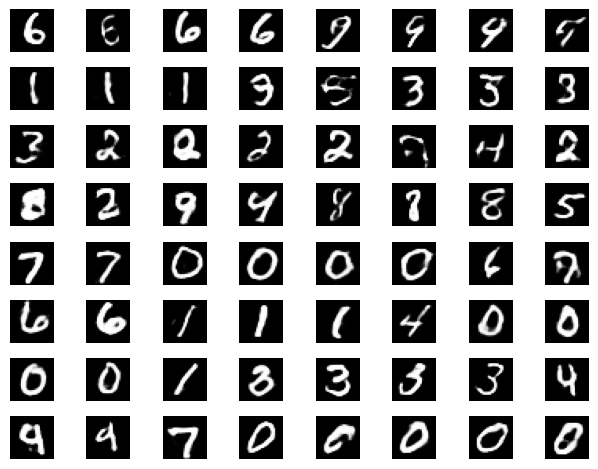

In [21]:
n_fakes = 64
fakes = model.generate_fakes(n_fakes=n_fakes)
plot_images(fakes)

While some of these digits look like they were produced by someone with handwriting even worse than mine, they're still a lot better than what we get by sampling a mixture of Gaussian directly fit on the image data: 

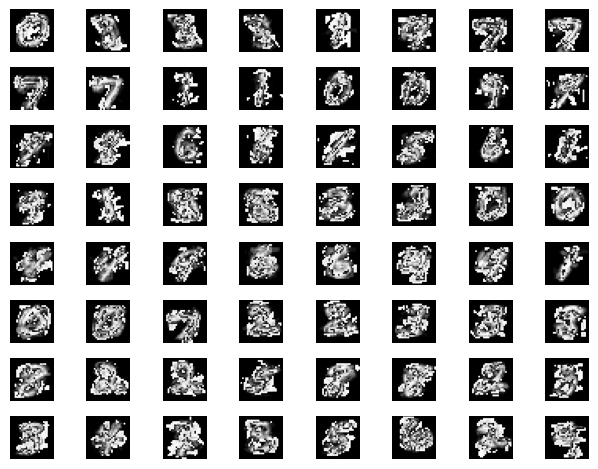

In [22]:
gmm_raw_data = GaussianMixture(n_components=100).fit(tf.reshape(x, [x.shape[0], x.shape[1] * x.shape[2]]).numpy())
fakes_from_raw, _ = gmm_raw_data.sample(n_samples=n_fakes)
plot_images(tf.reshape(fakes_from_raw, [n_fakes, 28, 28, 1]))

## What about images not in our training set?

I've been avoiding a question: where did these particles come from? They are a by-product of the training procedure (see [here](https://lpae.readthedocs.io/en/latest/)), which involves $N$ of them per image in our training set. So what about images not in our training set? How do we get such particles and representations for them? We can just emulate what we do in training and run one 'unadjusted Langevin algorithm' (ULA) chain per particle:

$$X_{k+1}^{n}=X_{k}^{n}+h'\nabla_x \ell(\Theta_K,X_{k}^{n})+\sqrt{2h}W_{k}^{n}, \quad\forall k=0,\dots,K'-1,\, n=1,\dots,N'$$

where 

- $y$ denotes the image,
- $\Theta_K$ the parameters learned during training, 
- $K'$ the number of steps we run the chains for,
- $N'$ the number of particles we wish to generate,
- $W_{1},\dots, W_{K'}$ independent zero-mean unit-variance Gaussian random variables,
- and $X_{K'}^1,\dots, X_{K'}^n$ the particles we generate (with $X_0^1,\dots,X_0^N$ independently drawn from $\mathcal{N}(0,I)$).

We can do this easily using the model's encode method:

In [23]:
model.encode(x_test[:3], n_steps=1000, step_size=1e-5, n_particles=2).shape

TensorShape([3, 2, 32])

## Recovering images corrupted with noise

We can clean images corrupted by noise by encoding the corrupted images (in particular, producing a single-particle-representation of each image using `model.encode`) and then decoding:

In [24]:
#@title Definition of corrupt()
def corrupt(images: tf.Tensor, noise_intensity: float = 0.3):
    images += noise_intensity * 255 * tf.random.normal(shape=images.shape)
    images *= 1 + noise_intensity * (tf.random.uniform(shape=images.shape) - 0.5)
    return tf.minimum(tf.maximum(images, 0), 255)

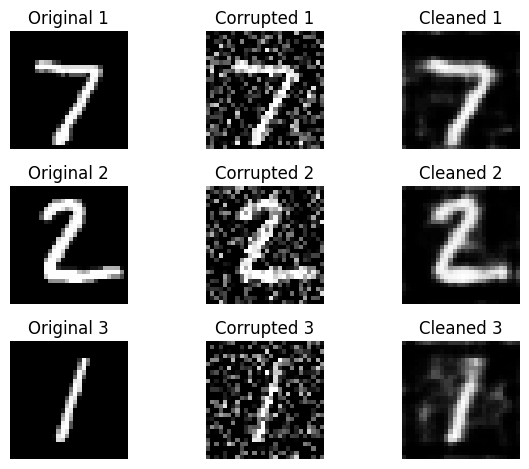

In [25]:
images = x_test[:3]
corrupted = corrupt(images)
reconstructed = model.decode(model.encode(corrupted))[:, 0, ...]  # equivalently: model(corrupted)
names = sum([[f'Original {i + 1}', f'Corrupted {i + 1}', f'Cleaned {i + 1}']
             for i in range(len(images))], [])
interweaved = tf.reshape(tf.stack([images, corrupted, reconstructed], axis=1),
                         (3 * len(images),) + images.shape[1:])
plot_images(interweaved, names)

## Classifying the images

<a id='classify_images'></a>

Lastly, we can train a simple single-layer classifier for the images using the [above representations](#visualize_particles). Because each image's representation is an unordered set of $N$ particles, we share weights across the particles:

                                                                       Classifier


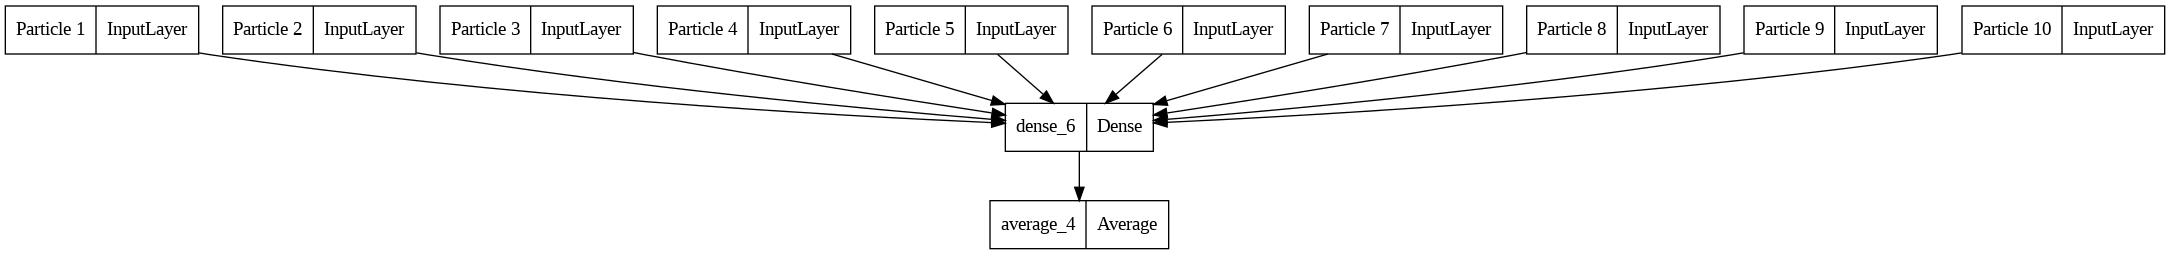

In [34]:
# Define classifier:
inputs = [Input(shape=(latent_dimensions,), name=f'Particle {i + 1}') for i in range(n_particles)]
fully_connected = Dense(10, input_shape=(latent_dimensions,), activation='softmax')
h = [fully_connected(particle) for particle in inputs]
output = Average()(h)
clf_rep = Model(inputs=inputs, outputs=output)
print(f'                                                                       Classifier')
print('=========================================================================================================================================================')
tf.keras.utils.plot_model(clf_rep)

In [27]:
# Train classifier:
particles = model.get_particles()
clf_rep.compile(optimizer='adam',
                loss=SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
clf_rep.fit([particles[:, i, :] for i in range(n_particles)], y, epochs=50, validation_split=0.2, 
             callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/50
250/250 [==============================] - 2s 6ms/step - loss: 4.8379 - accuracy: 0.2970 - val_loss: 2.5429 - val_accuracy: 0.4915
Epoch 2/50
250/250 [==============================] - 1s 4ms/step - loss: 1.5254 - accuracy: 0.6396 - val_loss: 1.1917 - val_accuracy: 0.7095
Epoch 3/50
250/250 [==============================] - 1s 4ms/step - loss: 0.8213 - accuracy: 0.7790 - val_loss: 0.8286 - val_accuracy: 0.7940
Epoch 4/50
250/250 [==============================] - 1s 6ms/step - loss: 0.5858 - accuracy: 0.8338 - val_loss: 0.6717 - val_accuracy: 0.8305
Epoch 5/50
250/250 [==============================] - 2s 7ms/step - loss: 0.4831 - accuracy: 0.8616 - val_loss: 0.5997 - val_accuracy: 0.8375
Epoch 6/50
250/250 [==============================] - 2s 7ms/step - loss: 0.4310 - accuracy: 0.8791 - val_loss: 0.5581 - val_accuracy: 0.8470
Epoch 7/50
250/250 [==============================] - 1s 4ms/step - loss: 0.4030 - accuracy: 0.8845 - val_loss: 0.5361 - val_accuracy: 0.8525
Epoch 

For this simple dataset, a naive single-layer classifier trained on the raw image data does just as well: 

In [28]:
# On raw images:
clf_raw = Sequential([Flatten(input_shape=(28, 28)), Dense(10)])
clf_raw.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
clf_raw.fit(x, y, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=2)])

Epoch 1/50
250/250 [==============================] - 1s 3ms/step - loss: 21.1337 - accuracy: 0.7186 - val_loss: 10.9496 - val_accuracy: 0.8370
Epoch 2/50
250/250 [==============================] - 1s 3ms/step - loss: 7.6593 - accuracy: 0.8595 - val_loss: 9.5010 - val_accuracy: 0.8605
Epoch 3/50
250/250 [==============================] - 1s 3ms/step - loss: 5.9629 - accuracy: 0.8766 - val_loss: 9.9682 - val_accuracy: 0.8490
Epoch 4/50
250/250 [==============================] - 1s 3ms/step - loss: 5.0666 - accuracy: 0.8913 - val_loss: 8.8665 - val_accuracy: 0.8745
Epoch 5/50
250/250 [==============================] - 1s 3ms/step - loss: 4.5839 - accuracy: 0.8931 - val_loss: 8.6007 - val_accuracy: 0.8600
Epoch 6/50
250/250 [==============================] - 1s 5ms/step - loss: 3.9482 - accuracy: 0.9065 - val_loss: 8.1469 - val_accuracy: 0.8725
Epoch 7/50
250/250 [==============================] - 1s 5ms/step - loss: 3.8171 - accuracy: 0.9040 - val_loss: 11.5006 - val_accuracy: 0.8355
Epo

However, the representation-based classifier is relatively robust to corruption,

In [29]:
corrupted_test = corrupt(x_test)
corrupted_test_enc = model.encode(corrupted_test, n_particles=n_particles)
_ = clf_rep.evaluate([corrupted_test_enc[:, i, :] for i in range(n_particles)], y_test)

32/32 [==============================] - 0s 3ms/step - loss: 1.0410 - accuracy: 0.7940


while the naive classifier is not:

In [30]:
_ = clf_raw.evaluate(corrupted_test, y_test)

32/32 [==============================] - 0s 2ms/step - loss: 86.4246 - accuracy: 0.4030
